In [1]:
import numpy as np
import scipy.stats as scs

In [27]:
def cond2(mu1,mu2,obs):
    out = np.zeros(len(obs)-1)
    for i in range(1,len(obs)):
        # compute individual log-densities
        out[i-1] = np.sum([np.power(obs[:i]-mu1,2)]) + np.sum([np.power(obs[i:]-mu2,2)])
    out = np.exp(out - np.mean(out))
    out = out /np.sum(out)
    out = np.nan_to_num(out,copy=False,nan=1.0)
    #print(out)
    return out

def dist_M(m, mu1, mu2, y):
    m = int(m)
    dist_M_log = -(1/2) * (np.sum((y[:m] - np.tile(mu1, m))**2) +
                           np.sum((y[m:] - np.tile(mu2, len(y)-m))**2))
    return dist_M_log

def cdist_M(mu1, mu2, y):
    #nprop_log_like = np.apply_along_axis(lambda k: dist_M(k, mu1, mu2, y), 0, np.arange(1, len(y)))
    nprop_log_like = [dist_M(k, mu1, mu2, y) for k in np.arange(1, len(y))]
    out = np.exp(nprop_log_like) / np.sum(np.exp(nprop_log_like))
    return out

def gibbs2(data,t):
    mu1s = [1] + np.zeros(t)
    mu2s = [0] + np.zeros(t)
    Ms = [1] + np.zeros(t)
    N = len(data)

    for i in range(1,t):
        #print(i,'-----------------')
        mu1s[i] = scs.norm( 100/((100)*Ms[i-1]+1) + np.mean(data[:int(Ms[i-1])]),100/((100)*Ms[i-1]+1)).rvs(1)
        #print(mu1s[i])
        mu2s[i] = scs.norm( 100/((100)*(N-Ms[i-1])+1) + np.mean(data[int(Ms[i-1]):]),100/((100)*(N-Ms[i-1])+1)).rvs(1)
        #print(mu2s[i])
        if np.random.uniform() < 0.9:
            Ms[i] = np.random.choice(np.arange(1,len(data)),p=cdist_M(mu1s[i],mu2s[i],data))
        else:
            Ms[i] = np.random.choice(np.arange(1,len(data)),p=cdist_M(mu1s[i],mu1s[i],data))
        #print(Ms[i])
    return np.array([mu1s,mu2s,Ms])

In [26]:
y = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
cdist_M(1, 0, y)

array([4.24748955e-18, 1.90359275e-17, 2.31905072e-16, 7.67964126e-15,
       6.91299275e-13, 1.69155355e-10, 1.12512269e-07, 2.03426955e-04,
       9.99796460e-01])

In [9]:
np.sum(cond2(1,1,np.concatenate((scs.norm(loc=1,scale=1).rvs(10),scs.norm(loc=10,scale=1).rvs(10)))))

0.9999999999999999

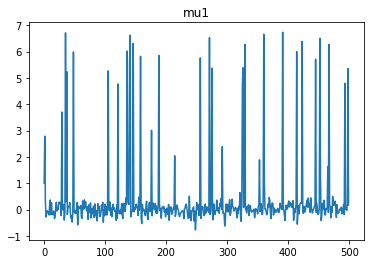

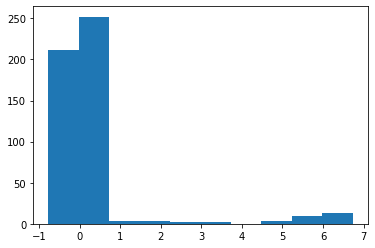

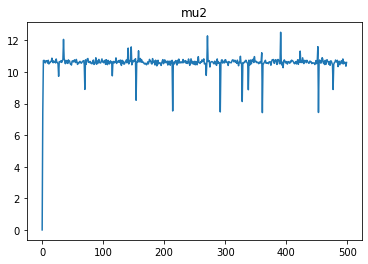

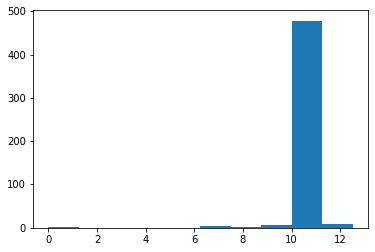

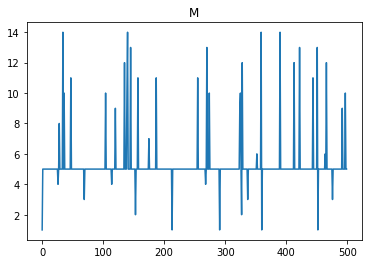

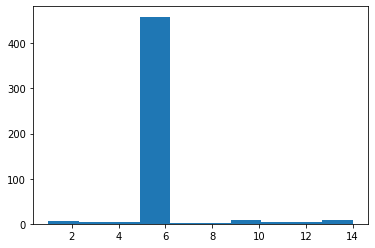

In [28]:
from matplotlib import pyplot as plt
test = gibbs2(np.append((np.random.normal(0,1,5)),(np.random.normal(10,1,10))),500)
plt.plot(test[0])
plt.title('mu1')
plt.show()
plt.hist(test[0])
plt.show()
plt.plot(test[1])
plt.title('mu2')
plt.show()
plt.hist(test[1])
plt.show()
plt.plot(test[2])
plt.title('M')
plt.show()
plt.hist(test[2])
plt.show()

In [131]:
# ABC style
from tqdm import tqdm
def prior_mu(x):
    return scs.norm(0,10).rvs(1)
def prior_M(len_):
    return np.random.choice(np.arange(1,len_-1),size=1)

def abc(data,t):
    mu1s = []
    mu2s = []
    Ms =  []
    stat = []
    for i in tqdm(range(1,t)):
        M_prop = int(prior_M(len(data)))
        mu1_prop = prior_mu(1)
        mu2_prop = prior_mu(1)
        sims = np.concatenate((scs.norm(mu1_prop,scale=1).rvs(M_prop),scs.norm(mu2_prop,scale=1).rvs(len(data)-M_prop)))
        mu1s.append(mu1_prop)
        mu2s.append(mu2_prop)
        Ms.append(M_prop)
        stat.append(scs.norm(mu1_prop,scale=1).logpdf(data[:M_prop]).sum()+scs.norm(mu2_prop,scale=1).logpdf(data[M_prop:]).sum())
        #stat.append( np.abs(np.mean(sims[:M_prop]) - np.mean(data[:M_prop]))+np.abs(np.mean(sims[M_prop:])-np.mean(data[:M_prop])))
    return np.array([mu1s,mu2s,Ms,stat])

100%|██████████| 9999/9999 [00:32<00:00, 308.62it/s]
C:\Users\david\AppData\Local\Temp\ipykernel_11656\1297929661.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([mu1s,mu2s,Ms,stat])


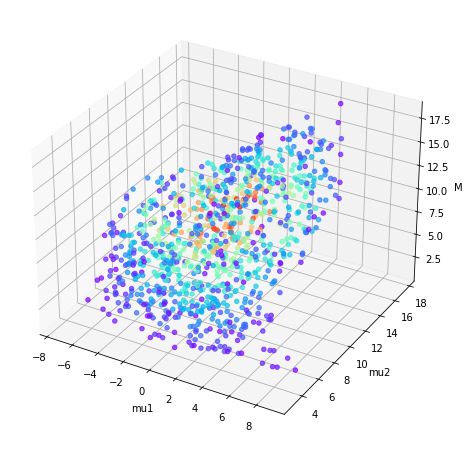

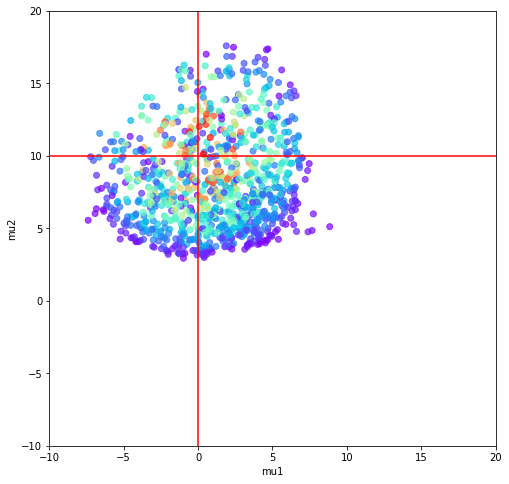

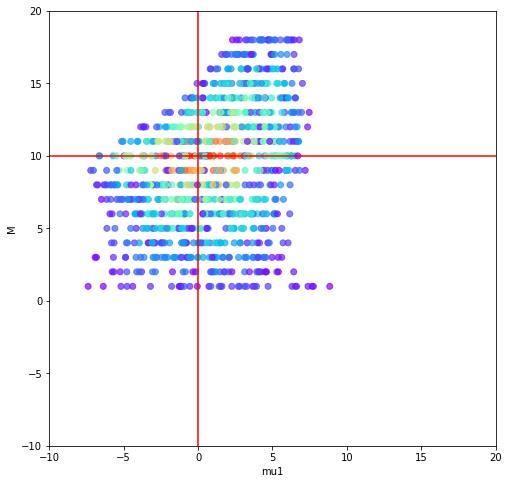

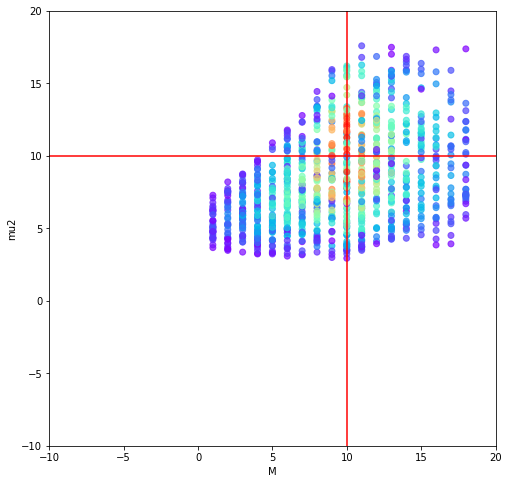

In [143]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Generate some test data
test = abc(np.append((np.random.normal(0,1,10)),(np.random.normal(10,1,10))),10000)

# Find the 95th percentile of the stat values
pct95 = np.percentile(test[3], 90)

# Select the quadruplets with stat in the top 5%
top5 = test[:, test[3] > pct95]

# Create a 3D scatter plot of the mu1, mu2, and M values
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(top5[0], top5[1], top5[2], c=top5[3], cmap=cm.rainbow, alpha=0.7)
ax.set_xlabel('mu1')
ax.set_ylabel('mu2')
ax.set_zlabel('M')
plt.show()

# Create a scatter plot of the mu1 and mu2 values
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(top5[0], top5[1], c=top5[3], cmap=cm.rainbow, alpha=0.7)
ax.axvline(0, color='red')
ax.axhline(10, color='red')
ax.set_xlabel('mu1')
ax.set_ylabel('mu2')
plt.xlim(-10, 20)
plt.ylim(-10, 20)

plt.show()

# Create a scatter plot of the mu1 and mu2 values
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(top5[0], top5[2], c=top5[3], cmap=cm.rainbow, alpha=0.7)
ax.set_xlabel('mu1')
ax.axhline(10, color='red')
ax.axvline(0, color='red')
plt.xlim(-10, 20)
plt.ylim(-10, 20)

ax.set_ylabel('M')
plt.show()

# Create a scatter plot of the mu1 and mu2 values
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(top5[2], top5[1], c=top5[3], cmap=cm.rainbow, alpha=0.7)
ax.set_xlabel('M')
ax.set_ylabel('mu2')
ax.axhline(10, color='red')
ax.axvline(10, color='red')
plt.xlim(-10, 20)
plt.ylim(-10, 20)

plt.show()